In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 
import random 
import warnings 
warnings.filterwarnings("ignore") 
import pickle
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier  
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
with open("BTC_USDT-4h-12.json") as f: 
    d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/11852 [00:00<?, ?it/s]

In [3]:
def preprocess_seq_data(chart_df, threshold=0.0075): 
    targets = [] 
    openv = chart_df["open"].values 
    close = chart_df["close"].values 
    high = chart_df["high"].values 
    low = chart_df["low"].values  
    volume = chart_df["volume"].values 
    
    for i in range(close.shape[0]-1):
        high_vol = (high[i+1] - close[i]) / close[i] 
        low_vol = (low[i+1] - close[i]) / close[i] 
        if high_vol >= threshold: 
            targets.append(0) 
        elif low_vol <= -threshold:
            targets.append(1) 
        else:
            targets.append(2) 
        
    targets.append(None) 
    chart_df["Targets"] = targets 
    
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/close"] = chart_df["high"] / chart_df["close"] 
    chart_df["low/close"] = chart_df["low"] / chart_df["close"]     
    for l in tqdm(range(1, 12), position=0, leave=True): 
        for col in ["open", "high", "low", "close", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret 

    chart_df.dropna(inplace=True) 
    chart_df.drop(columns={"open", "high", "low", "close", "volume"}, inplace=True) 
    return chart_df


  0%|          | 0/11 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Targets', ylabel='count'>

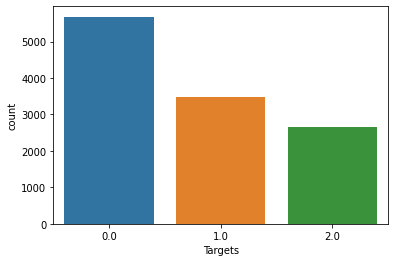

In [4]:
chart_df = preprocess_seq_data(chart_df) 

sns.countplot(chart_df, x="Targets")

In [5]:
train_columns = []
for col in chart_df.columns:
    if col not in ["Targets", "datetime", "years"]:
        train_columns.append(col)  

X = chart_df[train_columns] 
Y = chart_df["Targets"] 

train_size = int(chart_df.shape[0] * 0.8) 
val_size = int(chart_df.shape[0] * 0.1) 

X_train = X.iloc[:train_size] 
Y_train = Y.iloc[:train_size] 

X_val = X.iloc[train_size:train_size+val_size] 
Y_val = Y.iloc[train_size:train_size+val_size] 

X_test = X.iloc[train_size+val_size:] 
Y_test = Y.iloc[train_size+val_size:] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape 

((9449, 68), (9449,), (1181, 68), (1181,), (1182, 68), (1182,))

In [6]:
val = pd.concat([X_val, Y_val], axis=1) 
test = pd.concat([X_test, Y_test], axis=1) 

full_df = pd.concat([val, test], axis=0) 
full_df.shape

(2363, 69)

In [7]:
with open("ts2vec_similar_dates.pkl", "rb") as f: 
    similar_dict = pickle.load(f) 

In [9]:
comp_columns = train_columns[3:] 

date_chart_info = {} # date, index 

all_dates = chart_df.index 

for i in tqdm(range(len(all_dates)), position=0, leave=True): 
    date_chart_info[all_dates[i]] = i

  0%|          | 0/11812 [00:00<?, ?it/s]

# No Similar Patterns Used

In [10]:
train_size = int(0.8 * full_df.shape[0]) 
val_size = int(0.1 * full_df.shape[0]) 

train_df = full_df.iloc[:train_size] 
val_df = full_df.iloc[train_size:train_size+val_size] 
test_df = full_df.iloc[train_size+val_size:] 

train_df.shape, val_df.shape, test_df.shape

((1890, 69), (236, 69), (237, 69))

In [11]:
train_columns = [] 
for col in train_df.columns: 
    if col not in ["Targets"]: 
        train_columns.append(col) 

In [12]:
X_train = train_df[train_columns] 
Y_train = train_df["Targets"] 

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((1890, 68), (1890,), (236, 68), (236,), (237, 68), (237,))

In [13]:
clf = XGBClassifier(silent=False, 
                    n_estimators=200,
                    class_weight=d, 
                    metric="logloss",
                    tree_method="gpu_hist")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=20)

Y_pred = clf.predict(X_test)
cnt = 0 
for i in range(len(Y_pred)): 
    if Y_pred[i] == Y_test[i]: 
        cnt += 1 
        
accuracy = cnt / len(Y_pred) * 100
f1 = f1_score(Y_test, Y_pred, average="weighted") 

print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 

[09:18:07] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07640
[20]	validation_0-mlogloss:1.06534
[40]	validation_0-mlogloss:1.15647
[60]	validation_0-mlogloss:1.19999
[80]	validation_0-mlogloss:1.25483
[100]	validation_0-mlogloss:1.28639
[120]	validation_0-mlogloss:1.31688
[140]	validation_0-mlogloss:1.33819
[160]	validation_0-mlogloss:1.36550
[180]	validation_0-mlogloss:1.39386
[199]	vali

# With similar patterns used: scores softmax normalized 

In [14]:
accuracies, f1_scores = [], [] 

for topk in [5, 10, 15, 20, 25, 30]: 
    long_cnt, short_cnt, hold_cnt = [], [], [] 
    vote_accuracy = 0 
    for key, value in tqdm(similar_dict.items(), position=0, leave=True): 
        query_idx = date_chart_info[key] 
        query_target = chart_df["Targets"].iloc[query_idx] 
        cnt_map = {0:0, 1:0, 2:0} 
        for i in range(len(value[:topk])): 
            candidate_idx = date_chart_info[value[i][0]] 
            candidate_target = chart_df["Targets"].iloc[candidate_idx] 
            cnt_map[candidate_target] += 1 
        softmaxed = nn.Softmax()(torch.tensor([cnt_map[0], cnt_map[1], cnt_map[2]]).float()) 
        long_cnt.append(softmaxed[0].item()) 
        short_cnt.append(softmaxed[1].item()) 
        hold_cnt.append(softmaxed[2].item()) 
    
    full_df["long_vote"] = long_cnt 
    full_df["short_vote"] = short_cnt 
    full_df["hold_vote"] = hold_cnt 
        
    train_size = int(0.8 * full_df.shape[0]) 
    val_size = int(0.1 * full_df.shape[0]) 

    train_df = full_df.iloc[:train_size] 
    val_df = full_df.iloc[train_size:train_size+val_size] 
    test_df = full_df.iloc[train_size+val_size:]  
    
    train_columns = [] 
    for col in train_df.columns: 
        if col not in ["Targets"]: 
            train_columns.append(col) 
            
    X_train = train_df[train_columns] 
    Y_train = train_df["Targets"] 

    X_val = val_df[train_columns] 
    Y_val = val_df["Targets"] 

    X_test = test_df[train_columns] 
    Y_test = test_df["Targets"] 
    
    print("printing dataframe shapes") 
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)
    
    FE_clf = XGBClassifier(silent=False, 
                           n_estimators=200,
                           class_weight=d, 
                           metric="logloss",
                           tree_method="gpu_hist")  
    FE_clf.fit(X_train, 
               Y_train, 
               eval_set=[(X_val, Y_val)],
               verbose=20) 
    
    
    Y_pred = FE_clf.predict(X_test)

    cnt = 0 
    for i in range(len(Y_pred)): 
        if Y_pred[i] == Y_test[i]: 
            cnt += 1 

    accuracy = cnt / len(Y_pred) * 100
    f1 = f1_score(Y_test, Y_pred, average="weighted")
    
    print(f"Top {topk} similar patterns used") 
    print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 
    print("="*50) 
    
    accuracies.append(accuracy) 
    f1_scores.append(f1) 

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:35] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07698
[20]	validation_0-mlogloss:1.02140
[40]	validation_0-mlogloss:1.06222
[60]	validation_0-mlogloss:1.14723
[80]	validation_0-mlogloss:1.17261
[100]	validation_0-mlogloss:1.20981
[120]	validation_0-mlogloss:1.25945
[140]	validation_0-mlogloss:1.28266
[16

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:38] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07923
[20]	validation_0-mlogloss:1.06173
[40]	validation_0-mlogloss:1.10414
[60]	validation_0-mlogloss:1.16327
[80]	validation_0-mlogloss:1.20806
[100]	validation_0-mlogloss:1.24878
[120]	validation_0-mlogloss:1.27316
[140]	validation_0-mlogloss:1.30052
[16

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:40] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07831
[20]	validation_0-mlogloss:1.06267
[40]	validation_0-mlogloss:1.12465
[60]	validation_0-mlogloss:1.18870
[80]	validation_0-mlogloss:1.24750
[100]	validation_0-mlogloss:1.28143
[120]	validation_0-mlogloss:1.31321
[140]	validation_0-mlogloss:1.32529
[16

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:43] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07517
[20]	validation_0-mlogloss:1.07976
[40]	validation_0-mlogloss:1.11735
[60]	validation_0-mlogloss:1.15031
[80]	validation_0-mlogloss:1.21340
[100]	validation_0-mlogloss:1.26680
[120]	validation_0-mlogloss:1.29083
[140]	validation_0-mlogloss:1.33739
[16

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:46] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07693
[20]	validation_0-mlogloss:1.06861
[40]	validation_0-mlogloss:1.14111
[60]	validation_0-mlogloss:1.19495
[80]	validation_0-mlogloss:1.23449
[100]	validation_0-mlogloss:1.28782
[120]	validation_0-mlogloss:1.32542
[140]	validation_0-mlogloss:1.35422
[16

  0%|          | 0/2363 [00:00<?, ?it/s]

printing dataframe shapes
(1890, 71) (1890,) (236, 71) (236,) (237, 71) (237,)
[09:18:48] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.07703
[20]	validation_0-mlogloss:1.05284
[40]	validation_0-mlogloss:1.09760
[60]	validation_0-mlogloss:1.14480
[80]	validation_0-mlogloss:1.19137
[100]	validation_0-mlogloss:1.23803
[120]	validation_0-mlogloss:1.27590
[140]	validation_0-mlogloss:1.30752
[16

In [15]:
mean_accuracy = np.mean(accuracies) 
mean_f1 = np.mean(f1_scores) 

print(f"mean accuracy: {mean_accuracy}% | mean weighted F1: {mean_f1}") 

mean accuracy: 53.93811533052039% | mean weighted F1: 0.5947070218771784
